In [1]:
%ls

abbyy_course_cvdl_t3/
baseline_eval.ipynb
baseline_train.ipynb
centralnet_coco_text_third_try_epoch_0.pth
centralnet_coco_text_third_try_epoch_10.pth
centralnet_coco_text_third_try_epoch_15.pth
centralnet_coco_text_third_try_epoch_5.pth
cv-task3-third-try.ipynb
predictions.json
README.md
setup.py
third-try_eval.ipynb


In [2]:
%cd ../task2

/home/ichuviliaeva/cv_hw3/course_cvdl/task2


In [3]:
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.convert import ObjectsToPoints
from abbyy_course_cvdl_t2.loss import CenterNetLoss
from abbyy_course_cvdl_t2.network import CenterNet

/home/ichuviliaeva/miniconda3/envs/hw_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%cd ../task3/

/home/ichuviliaeva/cv_hw3/course_cvdl/task3


In [5]:
%ls

abbyy_course_cvdl_t3/
baseline_eval.ipynb
baseline_train.ipynb
centralnet_coco_text_third_try_epoch_0.pth
centralnet_coco_text_third_try_epoch_10.pth
centralnet_coco_text_third_try_epoch_15.pth
centralnet_coco_text_third_try_epoch_5.pth
cv-task3-third-try.ipynb
predictions.json
README.md
setup.py
third-try_eval.ipynb


In [6]:
from pathlib import Path
import numpy as np
import torch
import math
import warnings
from tqdm import tqdm
from abbyy_course_cvdl_t3.coco_text import COCO_Text

In [7]:
%ls /DATA/ichuviliaeva/coco_text/coco2014/images

test2014/  train2014/  val2014/


In [8]:
# base = Path("D:\\data\\Coco")
# anno_path = base / 'cocotext.v2.json'
# images_path = base / 'train2014'

anno_path = Path("./abbyy_course_cvdl_t3/data/cocotext.v2.json")
images_path = Path("/DATA/ichuviliaeva/coco_text/coco2014/images/train2014")

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


СOCO_Text взят из репозитория авторов датасета
https://github.com/andreasveit/coco-text/

In [9]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:01.957839
creating index...
index created!


#### Пример работы из репозитория coco-text
Взято из 
https://github.com/andreasveit/coco-text/blob/master/coco_text_Demo.ipynb

In [10]:
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible')])
# pick one at random
img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [11]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

Text(0.5, 1.0, 'Изображение из датасета COCO')

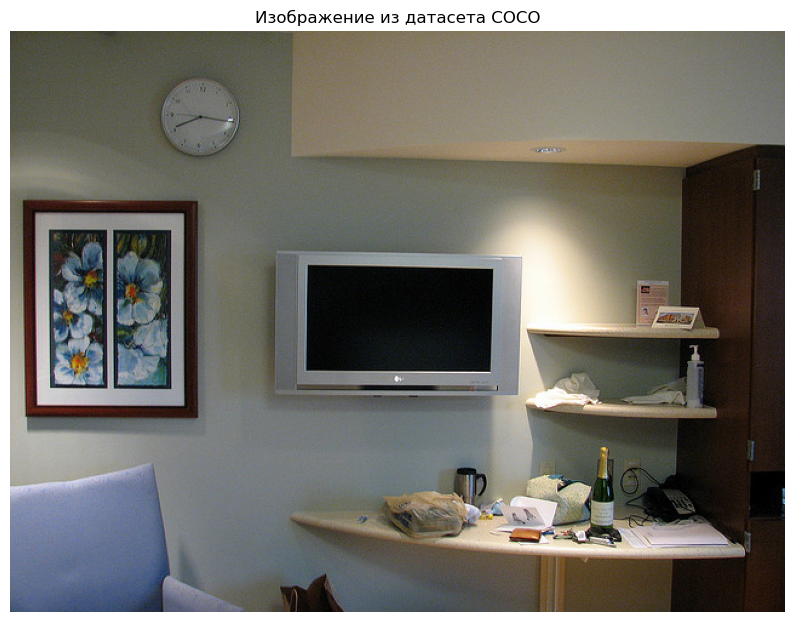

In [12]:
plt.imshow(plt.imread(images_path / img['file_name']))
plt.axis(False)
plt.title("Изображение из датасета COCO")

Text(0.5, 1.0, 'Изображение с GT детекциями текста')

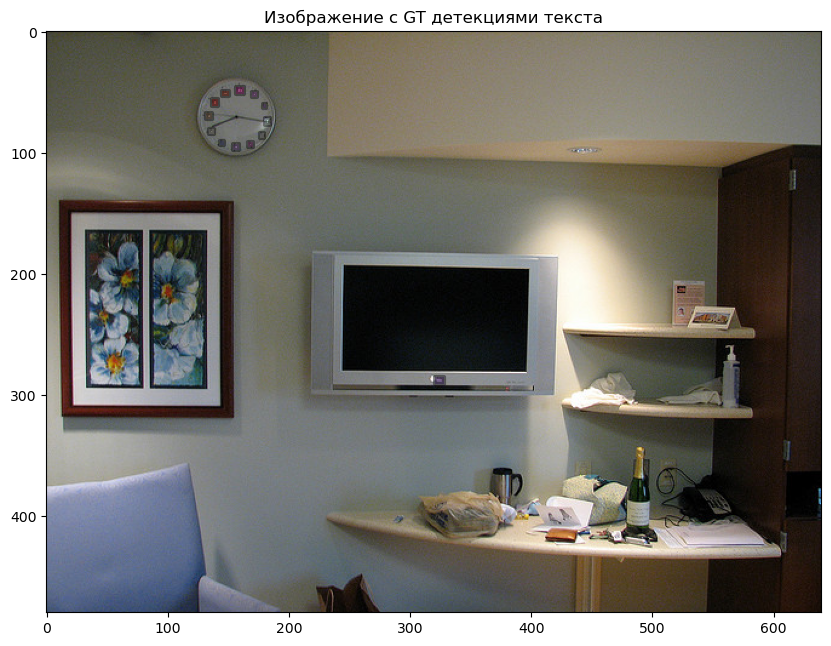

In [13]:
plt.imshow(plt.imread(images_path / img['file_name']))
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)
plt.title("Изображение с GT детекциями текста")

### Подготовка датасетов

In [14]:
!CUDA_VISIBLE_DEVICES="0"

In [15]:
torch.cuda.empty_cache()

In [16]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation


In [17]:
ds_train = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640))
)

In [18]:
ds_val = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640)),
    split='val'
)

### Подготовка модели


In [19]:
obj_to_points = ObjectsToPoints(hw=160, num_classes=1, smooth_kernel_size=3)
loss = CenterNetLoss(obj_to_points=obj_to_points)

In [20]:
net = CenterNet(head_kwargs={'c_classes': 1}, nms_kwargs={'kernel_size': 3})
crit = CenterNetLoss(obj_to_points=obj_to_points)

In [21]:
gpu = torch.device('cuda:0')

In [22]:
net = net.to(gpu);

### Тренировка

In [23]:
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json

In [24]:
def postprocess(preds, size_src=None, size_current=None):
    unfold_results = {}
    unf = {"scores": preds["scores"].cpu().detach().numpy()}
    b = preds["boxes"].clone().detach()
    boxes = b.clone()
    
    if size_src is not None and size_current is not None:
        mult_0 = size_src[0] / size_current[0]
        mult_1 = size_src[1] / size_current[1]

        boxes[:, 0] *= mult_0
        boxes[:, 2] *= mult_0
        boxes[:, 1] *= mult_1
        boxes[:, 3] *= mult_1
    unf['boxes'] = boxes.numpy()
        
    return unf

In [25]:
def train(train_dataset, val_dataset, *, net=None, criterion=None, 
          train_batch_size=1, val_batch_size = 1,  lr=3e-4, 
          epochs=1, start = 0, image_size=(640, 640), device=None):
    
    if net is None:
        net = CenterNet(pretrained=True)
    else:
        if start != 0:
            net = CenterNet(head_kwargs={'c_classes': 1}, nms_kwargs={'kernel_size': 3})
            net.load_state_dict(torch.load(last_path))
            net.train()
    if criterion is None:
        criterion = CenterNetLoss()

    if device is not None:
        net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    trainloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2
    )
    valloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=2
    )
    stats_step = (len(train_dataset) // 10 // train_batch_size) + 1
    for epoch in range(epochs):
        if epoch == 0:
            # на первой эпохе учимся с малым lr, чтобы не сломать pretrain
            optimizer.lr = lr / 1000
        else:
            # дальше постепенно уменьшаем
            optimizer.lr = lr / 2**epoch

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, anno = data
            inputs = inputs.to(device)
            anno = anno.to(device)
            optimizer.zero_grad()
            
            outputs = net(inputs)
            losses = criterion(outputs, anno).mean(axis=0)
            loss_value = losses.sum()
            if torch.isnan(loss_value).any():
                warnings.warn("nan loss! skip update")
                print(f"last loss: {[l.item() for l in losses]}")
                continue
            running_loss += loss_value
            if (i % stats_step == 0):
                print(f"epoch {epoch}|{i}; total loss:{running_loss / stats_step}")
                print(f"last losses: {[l.item() for l in losses.flatten()]}")
                running_loss = 0.0
            
            loss_value.backward()
            optimizer.step()
            
        if epoch % 5 == 0:
            torch.save(net, './centralnet_coco_text_third_try_epoch_' + str(epoch + start) + '.pth')
            last_path = './working/centralnet_coco_text_third_try_epoch_' + str(epoch + start) + '.pth'
                # print(f"Итоговый скор AP на val: {ap}")
            print('saved')
            net.train()
            
    print('Finished Training')
    return net


### Запуск тренировки

In [26]:
net = train(ds_train, ds_val, net=net, criterion=crit, 
            train_batch_size = 32, val_batch_size = 32, 
            epochs=30, device=torch.device('cuda:0'), lr=1e-3)

/home/ichuviliaeva/cv_hw3/course_cvdl/task2/abbyy_course_cvdl_t2/convert.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = torch.tensor(objects[:, :, 2]).to(objects.device)
/home/ichuviliaeva/cv_hw3/course_cvdl/task2/abbyy_course_cvdl_t2/convert.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(objects[:, :, 3]).to(objects.device)


epoch 0|0; total loss:2.6846985816955566
last losses: [122.61119079589844, 32.50941848754883, 5.961306571960449]
epoch 0|60; total loss:25.496963500976562
last losses: [0.02393961325287819, 2.017455816268921, 2.437947988510132]
epoch 0|120; total loss:4.195990562438965
last losses: [0.02523649111390114, 1.9198006391525269, 2.278409719467163]
epoch 0|180; total loss:4.188800811767578
last losses: [0.009310686029493809, 1.4483097791671753, 2.9907491207122803]
epoch 0|240; total loss:4.084654808044434
last losses: [0.009194585494697094, 2.7166292667388916, 2.634035348892212]
epoch 0|300; total loss:4.176833152770996
last losses: [0.006726924329996109, 1.2580962181091309, 2.945267677307129]
epoch 0|360; total loss:4.094554901123047
last losses: [0.0049846600741147995, 1.1590505838394165, 2.458643674850464]
epoch 0|420; total loss:4.066208839416504
last losses: [0.004470551386475563, 1.203989028930664, 2.7579193115234375]
epoch 0|480; total loss:4.1135382652282715
last losses: [0.0028187152

epoch 7|0; total loss:0.09520909190177917
last losses: [3.231657683500089e-05, 3.0538713932037354, 2.6586415767669678]
epoch 7|60; total loss:4.166062355041504
last losses: [4.9295045755570754e-05, 2.303480386734009, 2.283220052719116]
epoch 7|120; total loss:4.043138027191162
last losses: [3.728192314156331e-05, 1.2462455034255981, 2.6625821590423584]
epoch 7|180; total loss:4.156662464141846
last losses: [3.799992555286735e-05, 0.9335417151451111, 2.1917011737823486]
epoch 7|240; total loss:4.074063777923584
last losses: [3.7985912058502436e-05, 1.5996205806732178, 2.5088260173797607]
epoch 7|300; total loss:4.0991740226745605
last losses: [2.478402529959567e-05, 1.3870917558670044, 2.6004207134246826]
epoch 7|360; total loss:3.9851090908050537
last losses: [3.7596168112941086e-05, 1.4512251615524292, 2.4726250171661377]
epoch 7|420; total loss:4.148229598999023
last losses: [3.344515789649449e-05, 1.2994438409805298, 2.8396801948547363]
epoch 7|480; total loss:4.087162017822266
last

epoch 13|540; total loss:4.007225513458252
last losses: [5.447703188110609e-06, 0.9296613931655884, 2.515303611755371]
epoch 14|0; total loss:0.062155481427907944
last losses: [3.6949256809748476e-06, 1.17348051071167, 2.55584454536438]
epoch 14|60; total loss:4.14757776260376
last losses: [4.972882834408665e-06, 1.5468943119049072, 2.3657443523406982]
epoch 14|120; total loss:4.10343599319458
last losses: [2.5394763270014664e-06, 3.1918485164642334, 2.5776402950286865]
epoch 14|180; total loss:4.043595790863037
last losses: [4.308447842049645e-06, 1.56282377243042, 2.3426921367645264]
epoch 14|240; total loss:4.08947229385376
last losses: [3.2181201277126092e-06, 2.15714430809021, 2.754781484603882]
epoch 14|300; total loss:4.121640205383301
last losses: [3.926557383238105e-06, 1.3355847597122192, 2.258732557296753]
epoch 14|360; total loss:3.8979127407073975
last losses: [3.85096564059495e-06, 1.001254677772522, 2.0972511768341064]
epoch 14|420; total loss:3.9414031505584717
last los

epoch 20|480; total loss:4.056784152984619
last losses: [5.30131330833683e-07, 2.3847122192382812, 2.5714924335479736]
epoch 20|540; total loss:4.098097324371338
last losses: [4.017207970719028e-07, 1.5476504564285278, 2.653545379638672]
saved
epoch 21|0; total loss:0.062389545142650604
last losses: [3.437144471263309e-07, 1.0897926092147827, 2.6535794734954834]
epoch 21|60; total loss:4.047852039337158
last losses: [5.901533199903497e-07, 2.0169143676757812, 2.557908773422241]
epoch 21|120; total loss:3.8972513675689697
last losses: [6.575068596248457e-07, 1.2739588022232056, 2.6113946437835693]
epoch 21|180; total loss:4.190177917480469
last losses: [5.118736794429424e-07, 3.551452159881592, 2.395339012145996]
epoch 21|240; total loss:4.0128326416015625
last losses: [5.05788136706542e-07, 2.1004648208618164, 2.6291778087615967]
epoch 21|300; total loss:4.1783857345581055
last losses: [4.1549580487298954e-07, 1.309078335762024, 2.4262590408325195]
epoch 21|360; total loss:4.0418953895

epoch 27|420; total loss:4.153853893280029
last losses: [6.874891056440902e-08, 2.2652671337127686, 2.875437021255493]
epoch 27|480; total loss:3.993833303451538
last losses: [5.062474528472194e-08, 1.8574199676513672, 2.2991180419921875]
epoch 27|540; total loss:4.156065464019775
last losses: [9.24043277450437e-08, 2.098914384841919, 2.490949869155884]
epoch 28|0; total loss:0.09563326090574265
last losses: [7.816812086502978e-08, 3.1503448486328125, 2.5876505374908447]
epoch 28|60; total loss:4.038222312927246
last losses: [4.9355438846987454e-08, 1.5847338438034058, 2.6069962978363037]
epoch 28|120; total loss:4.200629234313965
last losses: [8.334860268632838e-08, 1.1796574592590332, 2.5434458255767822]
epoch 28|180; total loss:4.24959135055542
last losses: [5.335027353225996e-08, 1.4314764738082886, 2.5068275928497314]
epoch 28|240; total loss:4.044464588165283
last losses: [7.489720843523173e-08, 0.9621443748474121, 2.426461935043335]
epoch 28|300; total loss:4.101975917816162
las

In [28]:
%ls

abbyy_course_cvdl_t3/
baseline_eval.ipynb
baseline_train.ipynb
centralnet_coco_text_third_try_epoch_0.pth
centralnet_coco_text_third_try_epoch_10.pth
centralnet_coco_text_third_try_epoch_15.pth
centralnet_coco_text_third_try_epoch_20.pth
centralnet_coco_text_third_try_epoch_25.pth
centralnet_coco_text_third_try_epoch_5.pth
cv-task3-third-try.ipynb
predictions.json
README.md
setup.py
third-try_eval.ipynb
